In [5]:
import pandas as pd
import seaborn as sns
from nltk import FreqDist
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import os
import warnings
from wordcloud import WordCloud
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

os.chdir('/home/jai/Downloads/Data Science/TSEC Cancer')
 
data = pd.read_csv('nightly-ClinicalEvidenceSummaries.tsv', delimiter='\t')

data = data[['disease', 'drugs', 'clinical_significance']]
data = data.dropna()

data['disease'].value_counts()
data['drugs'].value_counts()
data['clinical_significance'].value_counts()

Sensitivity/Response    1119
Resistance               630
Reduced Sensitivity       12
Adverse Response           9
Name: clinical_significance, dtype: int64

In [4]:
# Frequency Counts

disease_freq = FreqDist()   
drug_freq = FreqDist()

for row in data.iterrows():
    disease_freq.update(row[1][0].replace(' ', '_').split())
    drug_freq.update(row[1][1].split(','))

drugs = pd.Series(drug_freq)
drugs = drugs.reset_index()
drugs.columns = ['drug', 'frequency']

diseases = pd.Series(disease_freq)
diseases = diseases.reset_index()
diseases.columns = ['disease', 'frequency']

highest_diseases = diseases.sort_values(by=['frequency'], ascending=False).iloc[:10]
highest_drugs = drugs.sort_values(by=['frequency'], ascending=False).iloc[:10]

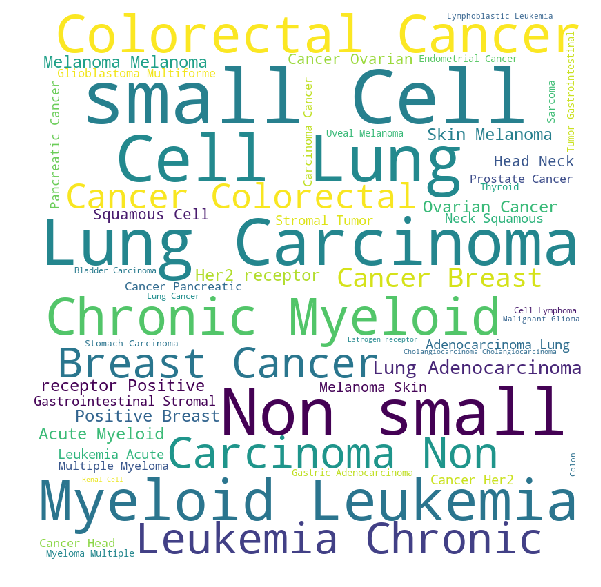

In [7]:
diseaseWords = ''

for row in data.iterrows():
    diseaseWords = diseaseWords + row[1][0] + ' '
    
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(diseaseWords) 
                          
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

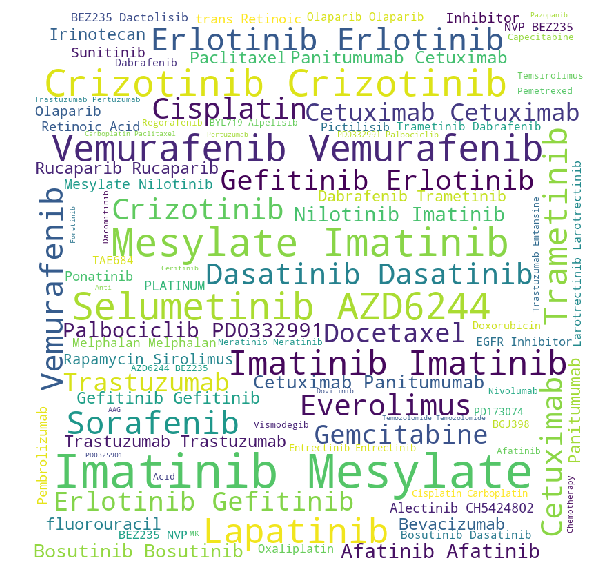

In [8]:
drugsWords = ''

for row in data.iterrows():
    drugsWords = drugsWords + row[1][1] + ' '
    
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(drugsWords) 
                          
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [9]:
# Selecting most frequent values

truncated_data = data.loc[data['disease'].isin(highest_diseases['disease'])]
truncated_data = truncated_data.loc[truncated_data['drugs'].isin(highest_drugs['drug'])]

truncated_data = truncated_data[truncated_data.clinical_significance != 'Reduced Sensitivity']
truncated_data = truncated_data[truncated_data.clinical_significance != 'Adverse Response']

truncated_data = truncated_data.reset_index()
truncated_data = truncated_data.drop(columns=['index'])

one_hot_disease = pd.get_dummies(truncated_data['disease'])
truncated_data = truncated_data.drop('disease', axis = 1)
truncated_data = truncated_data.join(one_hot_disease)
 
one_hot_drugs = pd.get_dummies(truncated_data['drugs'])
truncated_data = truncated_data.drop('drugs', axis = 1)
truncated_data = truncated_data.join(one_hot_drugs)

one_hot_clinical_significance = pd.get_dummies(truncated_data['clinical_significance'])
truncated_data = truncated_data.drop('clinical_significance', axis = 1)
truncated_data = truncated_data.join(one_hot_clinical_significance)
 
truncated_data = truncated_data.drop(columns=['Resistance'])

truncated_data = truncated_data.reset_index()
truncated_data = truncated_data.drop(columns=['index'])

In [10]:
# Predict using Random Forest Classifier

X_train, X_test, y_train, y_test = train_test_split(truncated_data.iloc[:, :8], 
                                                    truncated_data['Sensitivity/Response'], 
                                                    test_size=0.25, random_state=24)

classifier = RandomForestClassifier(n_estimators=300, random_state=0)  
classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test)

y_test = y_test.reset_index()
y_test = y_test.drop(columns=['index'])

acc = 0
for i in range(1, 18):
    if(y_pred[i-1]==y_test['Sensitivity/Response'][i-1]):
        acc += 1

print((acc/18)*100)

72.22222222222221


In [11]:
# Drugs with maximum success

successful_drugs_data = data.loc[data['clinical_significance'] == 'Sensitivity/Response']
successful_drugs_data = successful_drugs_data.drop(columns=['clinical_significance'])

successful_drugs_data = successful_drugs_data.reset_index()
successful_drugs_data = successful_drugs_data.drop(columns=['index'])

[[]]

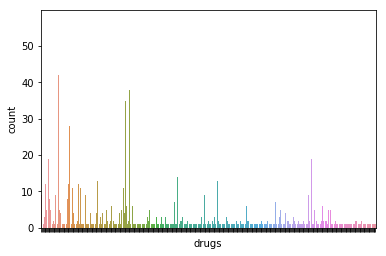

In [12]:
g = sns.countplot(successful_drugs_data['drugs'])
g.set(xticklabels=[])

Text(0.5,1,'Safest & Most Successful Drug Investment Options for Pharma Companies')

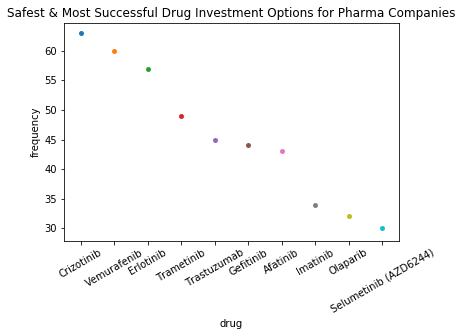

In [26]:
successful_drug_freq = FreqDist()

for row in successful_drugs_data.iterrows():
    successful_drug_freq.update(row[1][1].split(','))

successful_drugs = pd.Series(successful_drug_freq)
successful_drugs = successful_drugs.reset_index()
successful_drugs.columns = ['drug', 'frequency']
    

highest_successful_drugs = successful_drugs.sort_values(
                            by=['frequency'], ascending=False).iloc[:10]

highest_successful_drugs = highest_successful_drugs.reset_index()
highest_successful_drugs = highest_successful_drugs.drop(columns=['index'])

g = sns.swarmplot(highest_successful_drugs['drug'], highest_successful_drugs['frequency'])
g.set_xticklabels(g.get_xticklabels(), rotation=30)
g.set_title('Safest & Most Successful Drug Investment Options for Pharma Companies')

In [21]:
lowest_successful_drugs = successful_drugs.sort_values(
                            by=['frequency'], ascending=True).iloc[:10]

lowest_successful_drugs = lowest_successful_drugs.reset_index()
lowest_successful_drugs = lowest_successful_drugs.drop(columns=['index'])

print('High Risk & High Reward Drug Investment Options for Pharma Companies')
lowest_successful_drugs['drug'].value_counts()

High Risk & High Reward Drug Investment Options for Pharma Companies


Nutlin-3                                          1
Dovitinib Dilactic Acid (TKI258 Dilactic Acid)    1
Nutlin-3a                                         1
NU7441                                            1
Zoledronic Acid                                   1
Nintedanib                                        1
OICR-9429                                         1
NOTCH1 Antibody                                   1
O(6)-benzylguanine                                1
Dinaciclib                                        1
Name: drug, dtype: int64

In [24]:
highest_diseases_data = data.loc[data['disease'].isin(highest_diseases['disease'])]
highest_diseases_data = highest_diseases_data.loc[highest_diseases_data['clinical_significance'] == 'Sensitivity/Response']
highest_diseases_data = highest_diseases_data.drop(columns=['clinical_significance'])

print('Cancer & Melanoma are the Most Common Diseases with Successful Drug Usage')
highest_diseases_data['disease'].value_counts()

Cancer & Melanoma are the Most Common Diseases with Successful Drug Usage


Cancer      70
Melanoma    65
Name: disease, dtype: int64

Text(0.5,1,'Highest Demand Drug Investment Options for Pharma Companies')

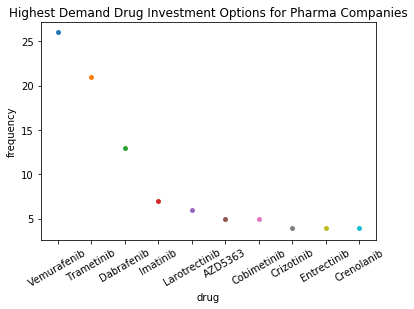

In [25]:
highest_diseases_drug = FreqDist()

for row in highest_diseases_data.iterrows():
    highest_diseases_drug.update(row[1][1].split(','))

highest_demand_drugs = pd.Series(highest_diseases_drug)
highest_demand_drugs = highest_demand_drugs.reset_index()
highest_demand_drugs.columns = ['drug', 'frequency']

highest_demand_drugs = highest_demand_drugs.sort_values(by=['frequency'], ascending=False).iloc[:10]

g = sns.swarmplot(highest_demand_drugs['drug'], highest_demand_drugs['frequency'])
g.set_xticklabels(g.get_xticklabels(), rotation=30)
g.set_title('Highest Demand Drug Investment Options for Pharma Companies')